In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np
from nff.io.ase_calcs import NeuralFF

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

/home/dux/NeuralForceField/models


Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

09:34:34 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
09:34:34 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [6]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

09:22:52 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3_001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
09:22:52 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
09:22:52 - mcmc.system | INFO: Initializing 64 virtual atoms
09:22:52 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
09:22:52 - mcmc.system | INFO: Number of pristine atoms is 60
09:22:52 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
09:22:52 - mcmc.

      Step     Time          Energy          fmax
BFGS:    0 09:22:53     -467.521881        0.204407
BFGS:    1 09:22:53     -467.525757        0.180273
BFGS:    2 09:22:53     -467.540619        0.079331
BFGS:    3 09:22:53     -467.540924        0.059820
BFGS:    4 09:22:54     -467.541351        0.005869


Calculate pristine surface energy

In [7]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [8]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

09:22:54 - mcmc.mcmc | INFO: Using run folder SrTiO3_001
09:22:54 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
09:22:54 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
09:22:54 - mcmc.mcmc | INFO: Starting with iteration 0
09:22:54 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
09:22:54 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:22:54     -469.542145        5.663930
BFGS:    1 09:22:54     -470.062103        3.748250
BFGS:    2 09:22:55     -470.705658        1.501063
BFGS:    3 09:22:55     -470.950348        1.263778
BFGS:    4 09:22:56     -471.057770        1.303539
BFGS:    5 09:22:56     -471.338776        1.157136
BFGS:    6 09:22:57     -471.263184        1.602936
BFGS:    7 09:22:57     -471.440308        0.762082
BFGS:    8 09:22:57     -471.475616        0.679113
BFGS:    9 09:22:57     -471.533325        1.313862
BFGS:   10 09:22:58     -471.561890        0.772159
BFGS:   11 09:22:58     -471.598053        0.321706
BFGS:   12 09:22:58     -471.623383        0.317807
BFGS:   13 09:22:58     -471.630951        0.309677
BFGS:   14 09:22:58     -471.637604        0.223591
BFGS:   15 09:22:59     -471.642914        0.189542
BFGS:   16 09:22:59     -471.647736        0.181848
BFGS:   17 09:23:00     -471.650909        0.195351
BFGS:   18 09:

09:23:29 - mcmc.system | INFO: Optimized structure has Energy = 5.251
09:23:29 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:23:29     -465.001740       58.731542
BFGS:    1 09:23:30     -479.482025       21.845519
BFGS:    2 09:23:30     -484.604279       10.891874
BFGS:    3 09:23:31     -488.084442        4.087891
BFGS:    4 09:23:31     -489.533783        3.095579
BFGS:    5 09:23:32     -489.967865        2.904286
BFGS:    6 09:23:32     -490.407257        2.691453
BFGS:    7 09:23:33     -490.856659        2.588631
BFGS:    8 09:23:33     -491.214355        2.369196
BFGS:    9 09:23:33     -491.617676        1.692762
BFGS:   10 09:23:33     -491.983002        1.919324
BFGS:   11 09:23:33     -492.406158        2.380275
BFGS:   12 09:23:34     -492.834229        2.677739
BFGS:   13 09:23:34     -493.579468        2.271513
BFGS:   14 09:23:34     -494.007233        2.269610
BFGS:   15 09:23:34     -494.481842        2.437358
BFGS:   16 09:23:34     -494.867279        2.150046
BFGS:   17 09:23:35     -495.315704        1.876575
BFGS:   18 09:

09:24:01 - mcmc.system | INFO: Optimized structure has Energy = 5.873
09:24:01 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:24:01     -462.468231       58.539233
BFGS:    1 09:24:01     -479.134033       22.061930
BFGS:    2 09:24:02     -487.285980       12.168998
BFGS:    3 09:24:03     -491.593475        5.631184
BFGS:    4 09:24:03     -493.966156        2.990607
BFGS:    5 09:24:03     -495.351807        3.313709
BFGS:    6 09:24:04     -496.362305        4.225584
BFGS:    7 09:24:04     -497.399994        4.004455
BFGS:    8 09:24:04     -498.345490        7.135082
BFGS:    9 09:24:04     -499.906250        5.479864
BFGS:   10 09:24:05     -500.992523        3.425910
BFGS:   11 09:24:05     -501.625824        2.482170
BFGS:   12 09:24:06     -502.499878        2.261966
BFGS:   13 09:24:06     -503.299896        3.962087
BFGS:   14 09:24:06     -504.236725        2.917761
BFGS:   15 09:24:07     -504.741058        2.738102
BFGS:   16 09:24:07     -505.464722        2.340507
BFGS:   17 09:24:07     -505.953339        2.231107
BFGS:   18 09:

09:24:20 - mcmc.system | INFO: Optimized structure has Energy = 4.658
09:24:20 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:24:20     -398.287750      136.527885
BFGS:    1 09:24:20     -429.865143       55.410595
BFGS:    2 09:24:20     -454.451569       75.370630
BFGS:    3 09:24:20     -455.645264      260.328248
BFGS:    4 09:24:20     -468.416992       20.980521
BFGS:    5 09:24:20     -473.047485       20.483212
BFGS:    6 09:24:20     -477.685883       13.695353
BFGS:    7 09:24:21     -480.930756       22.630272
BFGS:    8 09:24:21     -483.632324        7.293652
BFGS:    9 09:24:21     -485.716888        6.321367
BFGS:   10 09:24:21     -487.334137        3.947064
BFGS:   11 09:24:21     -488.478424        2.922112
BFGS:   12 09:24:21     -489.654144        6.098836
BFGS:   13 09:24:21     -490.613495       10.786877
BFGS:   14 09:24:21     -491.111786       16.093885
BFGS:   15 09:24:21     -491.833893        7.444038
BFGS:   16 09:24:21     -492.170990       17.288919
BFGS:   17 09:24:21     -492.442596        2.642178
BFGS:   18 09:

09:24:33 - mcmc.system | INFO: Optimized structure has Energy = 4.350
09:24:33 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:24:34     -442.156006       86.875950
BFGS:    1 09:24:34     -455.973480       65.661813
BFGS:    2 09:24:34     -475.137848       35.497316
BFGS:    3 09:24:34     -487.646637       19.665777
BFGS:    4 09:24:34     -496.924774       10.809924
BFGS:    5 09:24:34     -502.795074        5.173814
BFGS:    6 09:24:34     -506.175201        3.451179
BFGS:    7 09:24:35     -508.166595        3.094246
BFGS:    8 09:24:35     -509.425323        3.810758
BFGS:    9 09:24:35     -510.399628        3.152853
BFGS:   10 09:24:35     -511.298462        2.572249
BFGS:   11 09:24:35     -512.374695        2.489633
BFGS:   12 09:24:36     -512.746643        2.320597
BFGS:   13 09:24:36     -513.173828        1.819173
BFGS:   14 09:24:36     -513.400818        1.851031
BFGS:   15 09:24:36     -513.572144        1.611046
BFGS:   16 09:24:36     -513.755615        1.223009
BFGS:   17 09:24:36     -513.939148        0.845607
BFGS:   18 09:

09:24:49 - mcmc.system | INFO: Optimized structure has Energy = -0.380
09:24:49 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:24:49     -408.674561       86.305734
BFGS:    1 09:24:49     -421.689606       91.223792
BFGS:    2 09:24:49     -451.355469       86.255486
BFGS:    3 09:24:49     -468.069305       57.345063
BFGS:    4 09:24:50     -478.559570       16.038979
BFGS:    5 09:24:50     -484.996918       26.647133
BFGS:    6 09:24:50     -488.849731       13.110864
BFGS:    7 09:24:50     -490.638184       26.636951
BFGS:    8 09:24:50     -491.743561        5.419692
BFGS:    9 09:24:50     -492.965942        9.111239
BFGS:   10 09:24:50     -493.841034       16.948194
BFGS:   11 09:24:50     -494.151123       14.963826
BFGS:   12 09:24:50     -494.535614        4.308937
BFGS:   13 09:24:51     -494.868774        4.961884
BFGS:   14 09:24:51     -495.055573        2.286585
BFGS:   15 09:24:51     -495.245331        1.743710
BFGS:   16 09:24:51     -495.361359        2.739595
BFGS:   17 09:24:51     -495.454468        1.690511
BFGS:   18 09:

09:25:03 - mcmc.system | INFO: Optimized structure has Energy = -1.272
09:25:03 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:25:03     -422.647736       64.020363
BFGS:    1 09:25:03     -417.849213      265.331117
BFGS:    2 09:25:03     -454.722412      290.653466
BFGS:    3 09:25:03     -468.333038      153.766996
BFGS:    4 09:25:04     -477.365387      114.422113
BFGS:    5 09:25:04     -484.285553       24.972697
BFGS:    6 09:25:04     -488.257812        5.145539
BFGS:    7 09:25:04     -490.812164       41.919802
BFGS:    8 09:25:04     -492.591461       30.318401
BFGS:    9 09:25:04     -493.887115        4.774338
BFGS:   10 09:25:04     -495.526886       16.391107
BFGS:   11 09:25:04     -497.138214        9.136540
BFGS:   12 09:25:05     -497.817291       13.726324
BFGS:   13 09:25:05     -498.494537        2.066824
BFGS:   14 09:25:05     -499.549652        2.977712
BFGS:   15 09:25:05     -500.076416       17.602578
BFGS:   16 09:25:05     -500.459747        7.938179
BFGS:   17 09:25:05     -500.708618       13.024419
BFGS:   18 09:

09:25:16 - mcmc.system | INFO: Optimized structure has Energy = -2.478
09:25:16 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:25:16     -446.774323       91.046606
BFGS:    1 09:25:17     -460.078522       65.289907
BFGS:    2 09:25:17     -481.100494       33.660281
BFGS:    3 09:25:17     -494.069977       21.937317
BFGS:    4 09:25:17     -504.838379       10.797312
BFGS:    5 09:25:17     -511.099701        5.479110
BFGS:    6 09:25:17     -514.642029        3.055513
BFGS:    7 09:25:17     -516.672363        2.859149
BFGS:    8 09:25:17     -518.024475        2.602878
BFGS:    9 09:25:17     -518.962708        2.642570
BFGS:   10 09:25:18     -520.000244        2.349007
BFGS:   11 09:25:18     -520.961487        2.176319
BFGS:   12 09:25:18     -521.139221        1.421921
BFGS:   13 09:25:18     -521.486633        5.086923
BFGS:   14 09:25:18     -521.656494        1.689715
BFGS:   15 09:25:18     -521.849182        1.533655
BFGS:   16 09:25:18     -522.020447        7.585642
BFGS:   17 09:25:19     -522.183716        0.861827
BFGS:   18 09:

09:25:30 - mcmc.system | INFO: Optimized structure has Energy = -3.787
09:25:30 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:25:30     -363.784271      175.677194
BFGS:    1 09:25:30     -374.970306      118.763749
BFGS:    2 09:25:30     -417.929688      158.422503
BFGS:    3 09:25:30     -434.586670      245.643511
BFGS:    4 09:25:30     -447.543945       84.214860
BFGS:    5 09:25:31     -463.847534       86.382852
BFGS:    6 09:25:31     -473.340179       30.845624
BFGS:    7 09:25:31     -478.959473       46.310494
BFGS:    8 09:25:31     -484.678314       16.826210
BFGS:    9 09:25:31     -487.721832       17.024514
BFGS:   10 09:25:31     -489.480469       17.874114
BFGS:   11 09:25:32     -490.406464       15.873528
BFGS:   12 09:25:32     -491.539642        9.626888
BFGS:   13 09:25:32     -492.795563       59.345601
BFGS:   14 09:25:32     -491.362305       47.308712
BFGS:   15 09:25:32     -490.221283       93.019151
BFGS:   16 09:25:32     -493.686401       15.599027
BFGS:   17 09:25:32     -493.959351       18.380914
BFGS:   18 09:

09:25:43 - mcmc.system | INFO: Optimized structure has Energy = -3.687
09:25:43 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy          fmax
BFGS:    0 09:25:43     -422.720703       95.315312
BFGS:    1 09:25:43     -451.859619       64.680770
BFGS:    2 09:25:43     -477.216095       31.168305
BFGS:    3 09:25:43     -492.210846       21.166582
BFGS:    4 09:25:44     -506.497803       11.155960
BFGS:    5 09:25:44     -514.941223        6.195104
BFGS:    6 09:25:44     -519.662659        3.822920
BFGS:    7 09:25:44     -522.233826        2.254537
BFGS:    8 09:25:44     -523.540771        2.150771
BFGS:    9 09:25:44     -524.365540        2.375283
BFGS:   10 09:25:44     -525.387146        2.549501
BFGS:   11 09:25:44     -526.315063        1.443177
BFGS:   12 09:25:45     -526.669495        1.745572
BFGS:   13 09:25:45     -527.298767        2.000637
BFGS:   14 09:25:45     -527.617859        1.388727
BFGS:   15 09:25:45     -528.069824        2.464401
BFGS:   16 09:25:45     -528.373840        1.702220
BFGS:   17 09:25:45     -528.717102        1.775192
BFGS:   18 09:

09:25:58 - mcmc.system | INFO: Optimized structure has Energy = -3.687


Time taken = 184.408 seconds


Plot results

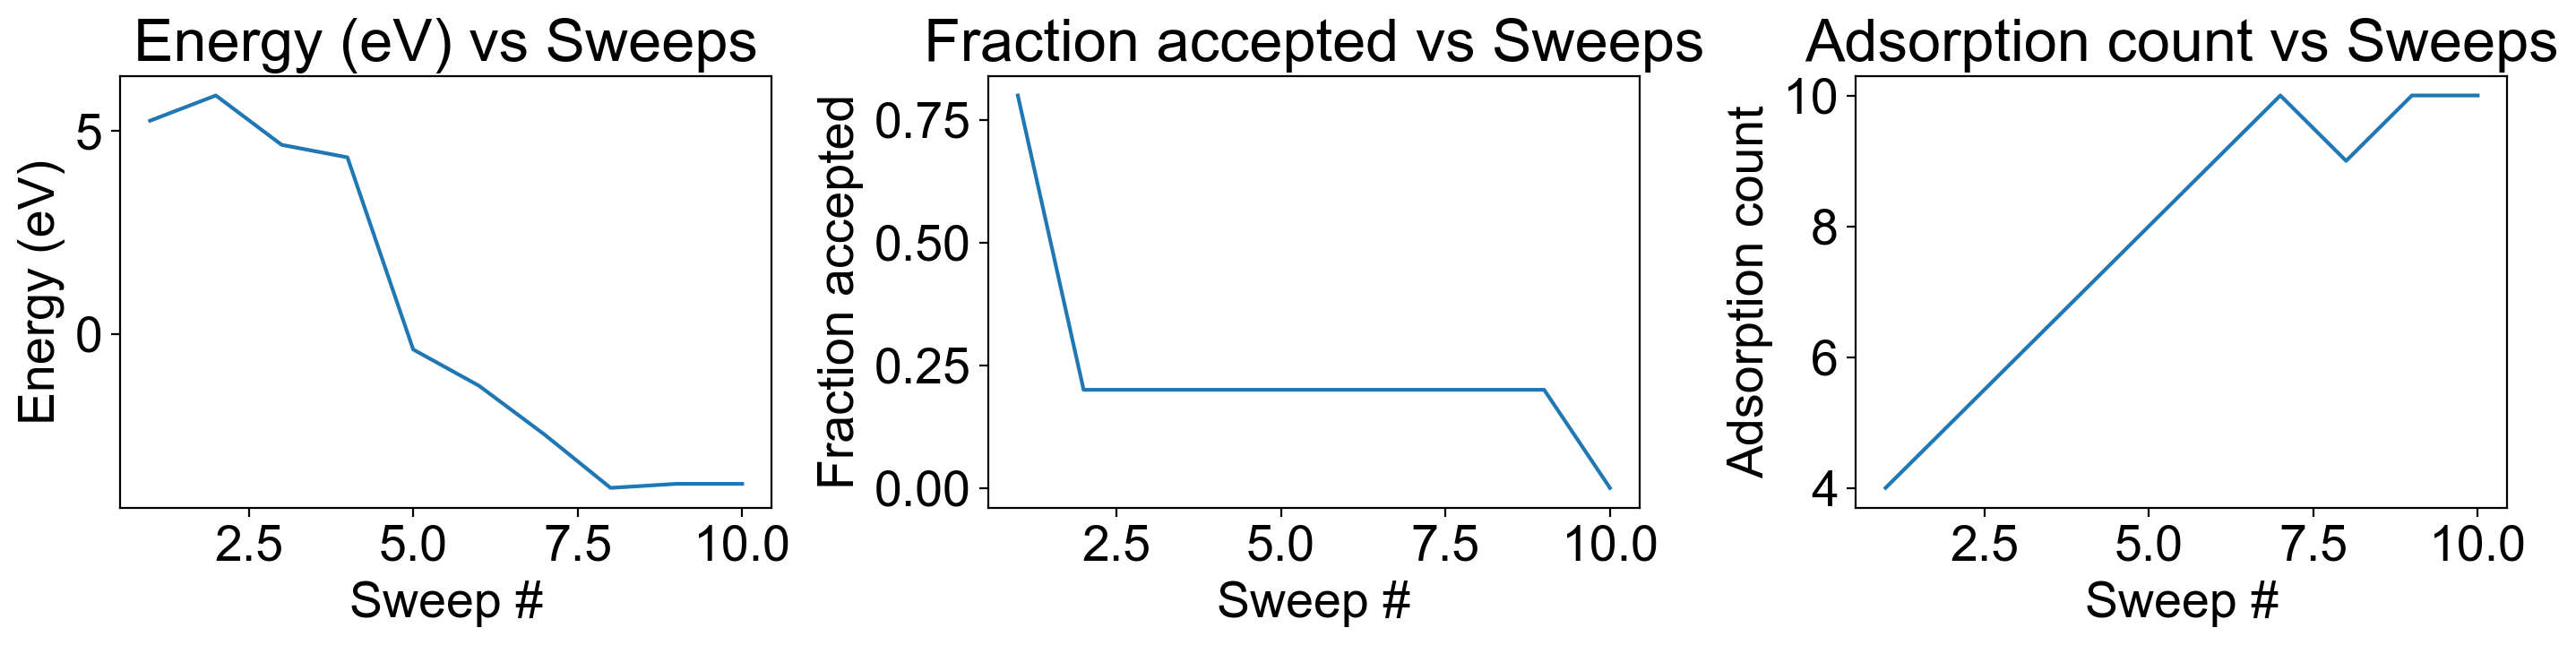

In [9]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [10]:
structures = results["history"]
with open("data/SrTiO3_001/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)